In [6]:
import pandas as pd
import numpy as np

# === 1) Source workbook (where RealEstate sheets live) ===
src = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis.xlsx"

# === 2) Helper to parse Bloomberg-style sheets (Dates/PX_LAST header) ===
def parse_bbg_sheet(df_raw, out_col):
    header_row = None
    for i, row in df_raw.iterrows():
        if (row.astype(str) == 'Dates').any() and (row.astype(str) == 'PX_LAST').any():
            header_row = i; break
    if header_row is None:
        raise ValueError("Could not find 'Dates'/'PX_LAST' header row.")
    df = df_raw.iloc[header_row:]
    df.columns = df.iloc[0]
    df = df.iloc[1:, :][['Dates', 'PX_LAST']].copy()
    df['Dates']   = pd.to_datetime(df['Dates'])
    df['PX_LAST'] = pd.to_numeric(df['PX_LAST'], errors='coerce')
    df = df.dropna(subset=['Dates']).set_index('Dates').sort_index()
    return df.rename(columns={'PX_LAST': out_col})

# === 3) Load Real Estate sheets (already CHF) ===
with pd.ExcelFile(src, engine="openpyxl") as xl:
    re_d_raw = xl.parse("RealEstateCHF daily",  header=None)
    re_w_raw = xl.parse("RealEstateCHF weekly", header=None)

re_d = parse_bbg_sheet(re_d_raw, "RealEstate_CHF_Last")
re_w = parse_bbg_sheet(re_w_raw, "RealEstate_CHF_Last")

# === 4) Compute log returns (daily & weekly) ===
re_d['RealEstate_ret'] = np.log(re_d['RealEstate_CHF_Last']).diff()
re_w['RealEstate_ret'] = np.log(re_w['RealEstate_CHF_Last']).diff()

re_d = re_d.dropna(subset=['RealEstate_ret'])
re_w = re_w.dropna(subset=['RealEstate_ret'])

# === 5) Save neat outputs ===
out = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_RealEstateCHF_returns.xlsx"
with pd.ExcelWriter(out, engine='openpyxl') as writer:
    re_d.to_excel(writer, sheet_name="RealEstateCHF daily + ret")
    re_w.to_excel(writer, sheet_name="RealEstateCHF weekly + ret")

print("✅ Real Estate (CHF) returns saved to:", out)


✅ Real Estate (CHF) returns saved to: C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_RealEstateCHF_returns.xlsx


=== Daily Real Estate Log Returns (CHF) ===
count    2557.000000
mean        0.000108
std         0.007504
min        -0.082355
25%        -0.003489
50%         0.000000
75%         0.003949
max         0.046329
Name: RealEstate_ret, dtype: float64

=== Weekly Real Estate Log Returns (CHF) ===
count    530.000000
mean       0.000568
std        0.015409
min       -0.086701
25%       -0.008370
50%        0.000877
75%        0.010016
max        0.044518
Name: RealEstate_ret, dtype: float64


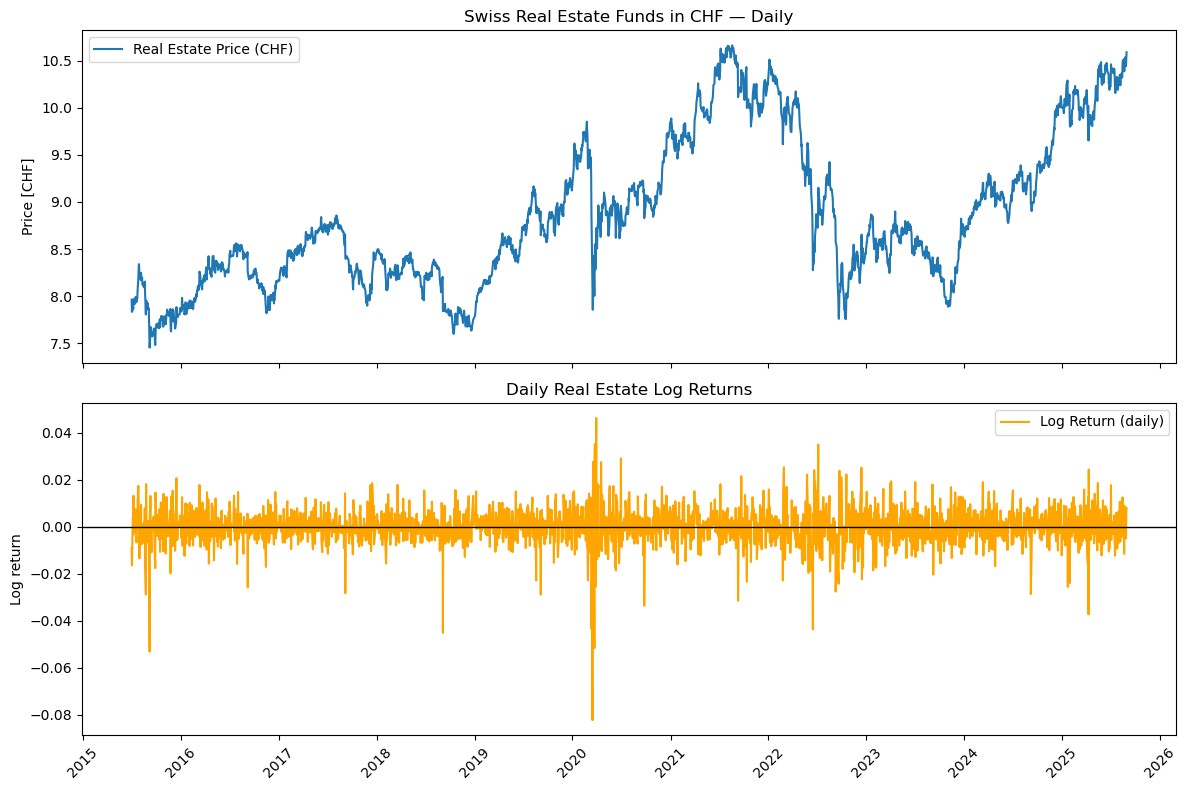

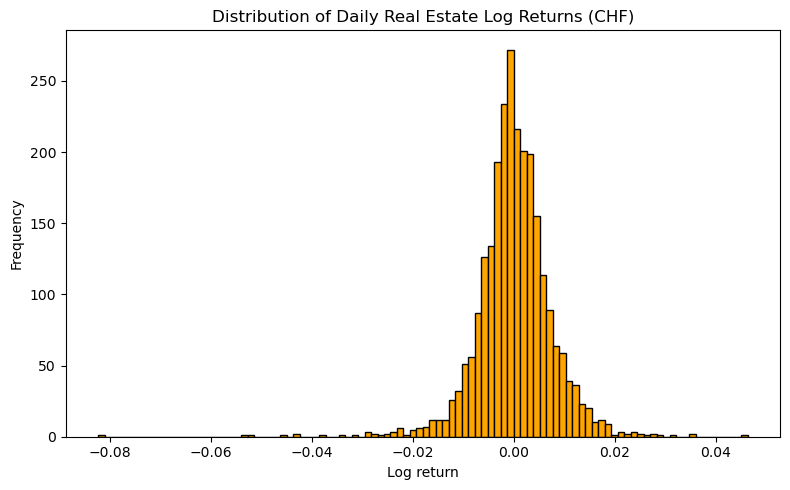

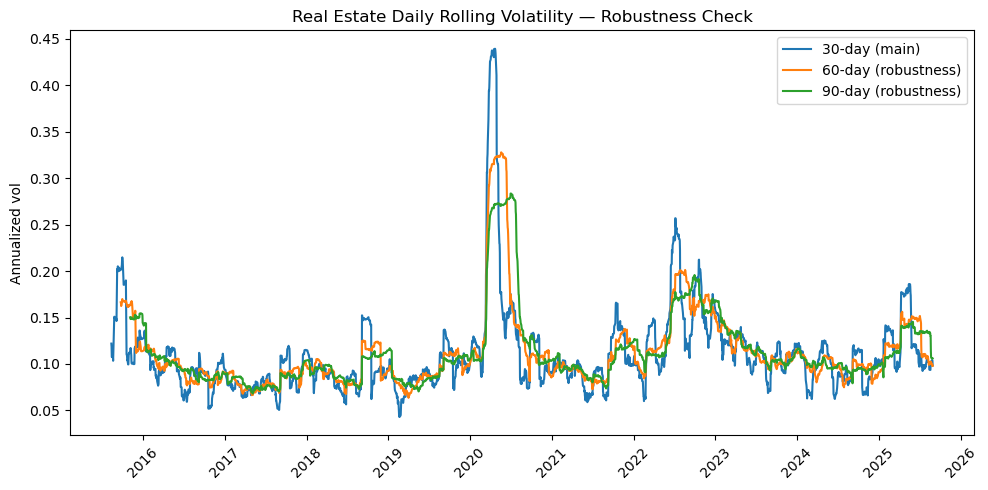

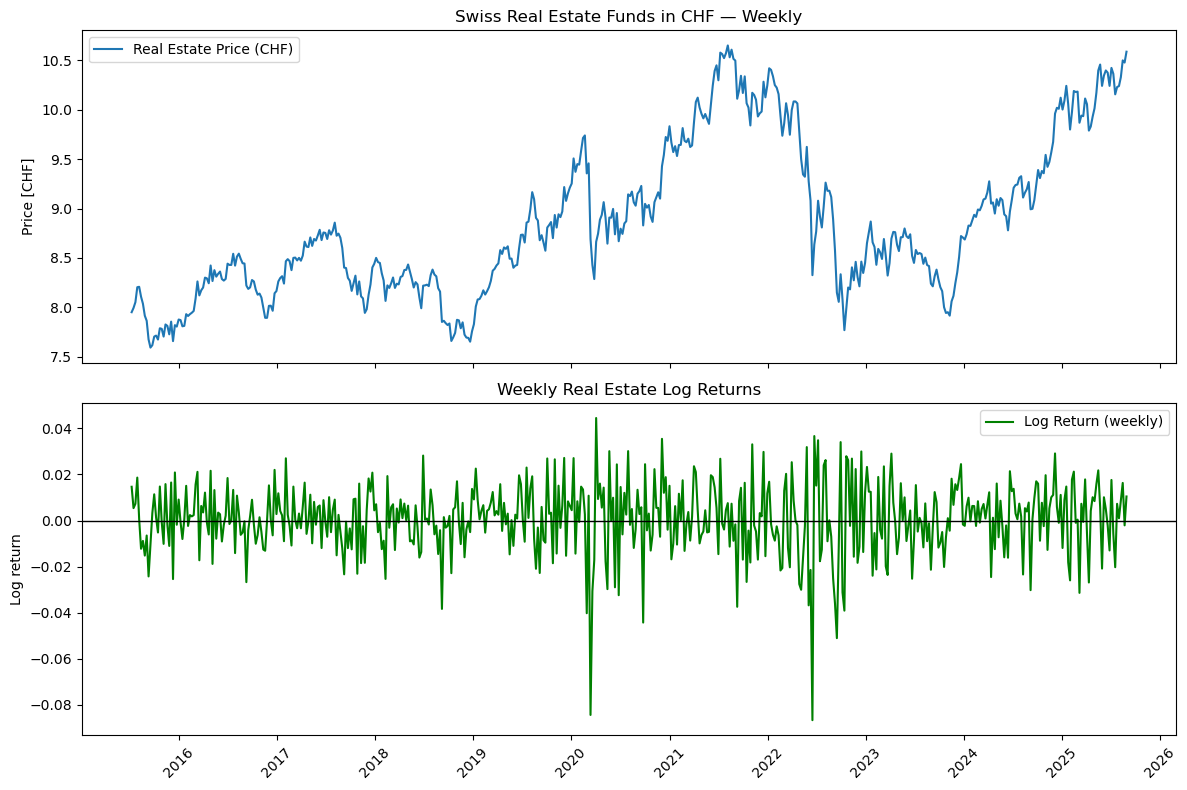

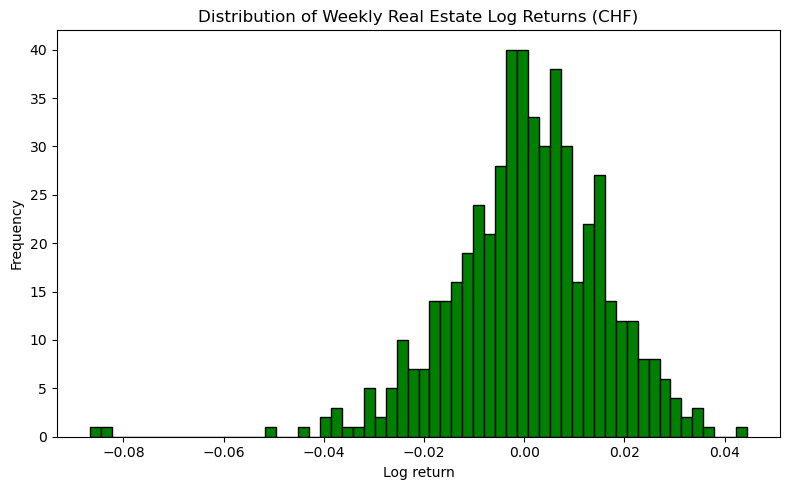

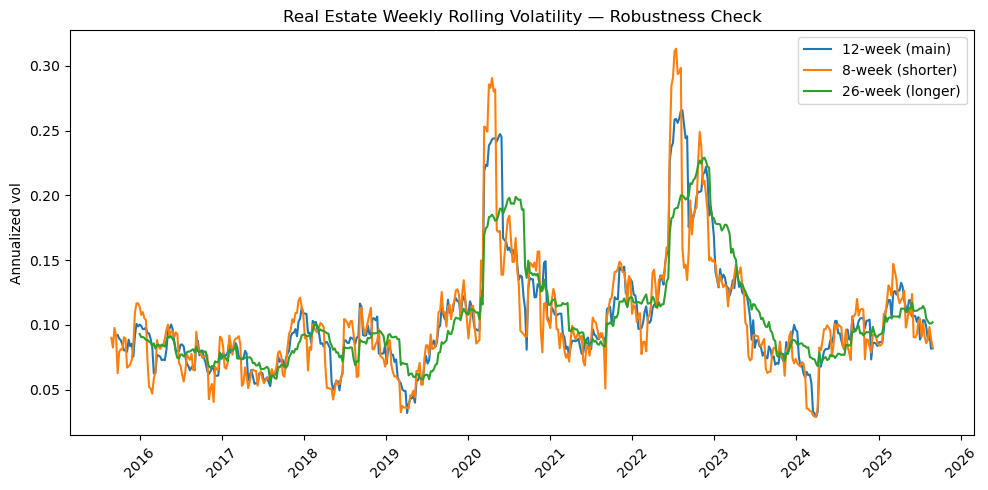

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1) Load saved Real Estate returns ===
path = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_RealEstateCHF_returns.xlsx"
re_d = pd.read_excel(path, sheet_name="RealEstateCHF daily + ret", index_col=0, parse_dates=True)
re_w = pd.read_excel(path, sheet_name="RealEstateCHF weekly + ret", index_col=0, parse_dates=True)

# === 2) Descriptive statistics ===
print("=== Daily Real Estate Log Returns (CHF) ===")
print(re_d['RealEstate_ret'].describe())
print("\n=== Weekly Real Estate Log Returns (CHF) ===")
print(re_w['RealEstate_ret'].describe())

# === Helper to format x-axis with years ===
def set_year_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

# === 3) Daily: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(re_d.index, re_d['RealEstate_CHF_Last'], label='Real Estate Price (CHF)')
ax[0].set_title('Swiss Real Estate Funds in CHF — Daily')
ax[0].set_ylabel('Price [CHF]')
ax[0].legend()
set_year_axis(ax[0])

ax[1].plot(re_d.index, re_d['RealEstate_ret'], color='orange', label='Log Return (daily)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Daily Real Estate Log Returns')
ax[1].set_ylabel('Log return')
ax[1].legend()
set_year_axis(ax[1])

plt.tight_layout()
plt.show()

# === 4) Daily histogram ===
plt.figure(figsize=(8,5))
plt.hist(re_d['RealEstate_ret'].dropna(), bins=100, color='orange', edgecolor='black')
plt.title('Distribution of Daily Real Estate Log Returns (CHF)')
plt.xlabel('Log return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# === 5) Daily rolling vol (30d main) + robustness (60/90d), annualized √252 ===
re_d['RollingVol30'] = re_d['RealEstate_ret'].rolling(30).std()
re_d['RollingVol60'] = re_d['RealEstate_ret'].rolling(60).std()
re_d['RollingVol90'] = re_d['RealEstate_ret'].rolling(90).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(re_d.index, re_d['RollingVol30'] * np.sqrt(252), label='30-day (main)')
ax.plot(re_d.index, re_d['RollingVol60'] * np.sqrt(252), label='60-day (robustness)')
ax.plot(re_d.index, re_d['RollingVol90'] * np.sqrt(252), label='90-day (robustness)')
ax.set_title('Real Estate Daily Rolling Volatility — Robustness Check')
ax.set_ylabel('Annualized vol')
ax.legend()
set_year_axis(ax)
plt.tight_layout()
plt.show()

# === 6) Weekly: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(re_w.index, re_w['RealEstate_CHF_Last'], label='Real Estate Price (CHF)')
ax[0].set_title('Swiss Real Estate Funds in CHF — Weekly')
ax[0].set_ylabel('Price [CHF]')
ax[0].legend()
set_year_axis(ax[0])

ax[1].plot(re_w.index, re_w['RealEstate_ret'], color='green', label='Log Return (weekly)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Weekly Real Estate Log Returns')
ax[1].set_ylabel('Log return')
ax[1].legend()
set_year_axis(ax[1])

plt.tight_layout()
plt.show()

# === 7) Weekly histogram ===
plt.figure(figsize=(8,5))
plt.hist(re_w['RealEstate_ret'].dropna(), bins=60, color='green', edgecolor='black')
plt.title('Distribution of Weekly Real Estate Log Returns (CHF)')
plt.xlabel('Log return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# === 8) Weekly rolling vol (12w main) + robustness (8/26w), annualized √52 ===
re_w['RollingVol12w'] = re_w['RealEstate_ret'].rolling(12).std()
re_w['RollingVol8w']  = re_w['RealEstate_ret'].rolling(8).std()
re_w['RollingVol26w'] = re_w['RealEstate_ret'].rolling(26).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(re_w.index, re_w['RollingVol12w'] * np.sqrt(52), label='12-week (main)')
ax.plot(re_w.index, re_w['RollingVol8w']  * np.sqrt(52), label='8-week (shorter)')
ax.plot(re_w.index, re_w['RollingVol26w'] * np.sqrt(52), label='26-week (longer)')
ax.set_title('Real Estate Weekly Rolling Volatility — Robustness Check')
ax.set_ylabel('Annualized vol')
ax.legend()
set_year_axis(ax)
plt.tight_layout()
plt.show()
